# 🔍 Phase 1 Enhanced Data Exploration
## Discovering Hidden Insights for Phase 2 Upgrades

**Purpose:** Explore what additional analyses we can do with our Phase 1 data

**What you'll discover:**
1. Directional patterns (wave/wind direction impacts)
2. Weather windows (consecutive workable days)
3. Persistence patterns (how long do conditions last?)
4. Wave steepness (affects vessel motions)
5. Seasonal details (weekly patterns)
6. Year-over-year trends
7. Time-of-day patterns
8. Combined Hs+Tp limits

---

## Part 1: Load Data and Check What We Have

In [1]:
# Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)

%matplotlib inline

print("✅ Libraries loaded!")

✅ Libraries loaded!


In [2]:
# Load cleaned data
df = pd.read_parquet('../data/processed/timeseries/UK_NortheastCoast_2015_2025_cleaned.parquet')

print("=" * 80)
print("DATA INVENTORY")
print("=" * 80)

print(f"\n📊 Dataset:")
print(f"  Records: {len(df):,}")
print(f"  Time range: {df['time'].min()} to {df['time'].max()}")
print(f"  Duration: {(df['time'].max() - df['time'].min()).days} days")

print(f"\n📋 Available variables:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i}. {col}")

print(f"\n👀 Sample:")
print(df.head())

DATA INVENTORY

📊 Dataset:
  Records: 15,859
  Time range: 2015-01-01 00:00:00 to 2025-11-08 12:00:00
  Duration: 3964 days

📋 Available variables:
  1. time
  2. hs
  3. tp
  4. dir
  5. wind_u
  6. wind_v
  7. wind_speed
  8. month
  9. month_name

👀 Sample:
                 time        hs        tp         dir     wind_u     wind_v  \
0 2015-01-01 00:00:00  1.788754  5.521828  201.499268   5.959814  10.596545   
1 2015-01-01 06:00:00  1.297573  5.639015  202.063553   3.951309   8.450397   
2 2015-01-01 12:00:00  1.801332  5.402687  188.969910   3.231293  11.774301   
3 2015-01-01 18:00:00  2.500455  6.356300  198.457153   8.083596  11.590133   
4 2015-01-02 00:00:00  3.188416  6.959816  234.631287  15.009109   4.351538   

   wind_speed  month month_name  
0   12.157556      1        Jan  
1    9.328561      1        Jan  
2   12.209644      1        Jan  
3   14.130666      1        Jan  
4   15.627195      1        Jan  


---
## Part 2: Directional Analysis

**Why it matters:** Some operations have directional limits!
- Vessel heading restrictions
- Beam seas (side-on waves) more dangerous than head/stern seas
- Wind direction affects crane operations

In [3]:
print("=" * 80)
print("🧭 DIRECTIONAL ANALYSIS")
print("=" * 80)

# Check if we have direction data
if 'dir' in df.columns:
    print("\n✅ Wave direction available!")
    print(f"  Range: {df['dir'].min():.1f}° to {df['dir'].max():.1f}°")
    print(f"  Mean: {df['dir'].mean():.1f}°")
    
    # Calculate wind direction from components
    if 'wind_u' in df.columns and 'wind_v' in df.columns:
        # Wind direction: where wind is FROM (meteorological convention)
        df['wind_dir'] = (np.degrees(np.arctan2(-df['wind_u'], -df['wind_v'])) + 360) % 360
        print(f"\n✅ Wind direction calculated!")
        print(f"  Range: {df['wind_dir'].min():.1f}° to {df['wind_dir'].max():.1f}°")
        print(f"  Mean: {df['wind_dir'].mean():.1f}°")
    
    # Directional distribution
    print(f"\n📊 Wave direction distribution:")
    sectors = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
    sector_bounds = [0, 45, 90, 135, 180, 225, 270, 315, 360]
    
    for i, sector in enumerate(sectors):
        lower = sector_bounds[i]
        upper = sector_bounds[i+1]
        count = ((df['dir'] >= lower) & (df['dir'] < upper)).sum()
        pct = count / len(df) * 100
        bar = '█' * int(pct / 2)
        print(f"  {sector:3s} ({lower:3.0f}-{upper:3.0f}°): {pct:5.1f}% {bar}")
    
    print(f"\n💡 Insight: Dominant wave direction = {sectors[np.argmax([((df['dir'] >= sector_bounds[i]) & (df['dir'] < sector_bounds[i+1])).sum() for i in range(len(sectors))])]}")
    
else:
    print("\n⚠️  Wave direction not in cleaned data")
    print("   (May still be in raw NetCDF files - can be extracted!)")

🧭 DIRECTIONAL ANALYSIS

✅ Wave direction available!
  Range: 0.0° to 360.0°
  Mean: 163.8°

✅ Wind direction calculated!
  Range: 0.0° to 360.0°
  Mean: 201.9°

📊 Wave direction distribution:
  N   (  0- 45°):  23.5% ███████████
  NE  ( 45- 90°):  12.1% ██████
  E   ( 90-135°):   9.6% ████
  SE  (135-180°):  10.8% █████
  S   (180-225°):   9.1% ████
  SW  (225-270°):   9.4% ████
  W   (270-315°):   9.7% ████
  NW  (315-360°):  15.8% ███████

💡 Insight: Dominant wave direction = N


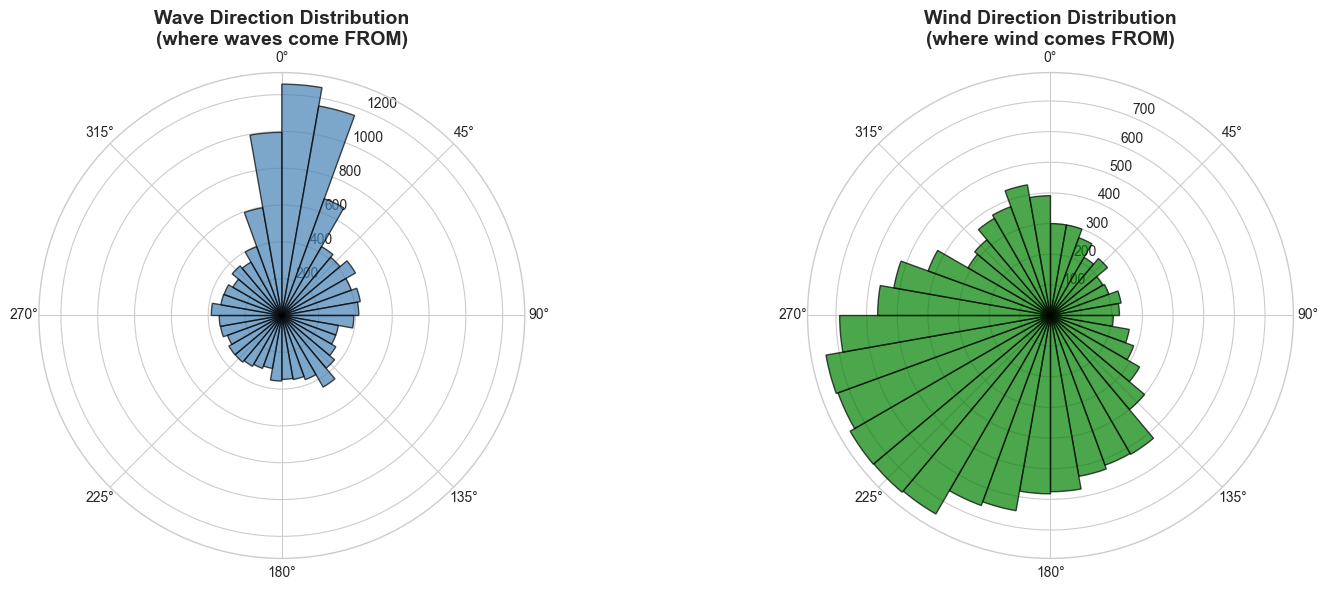


💡 Direction roses show:
   • Longer bars = More frequent from that direction
   • North is at top (0°)
   • Directions show where waves/wind come FROM


In [4]:
# Visualize directions
if 'dir' in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), subplot_kw=dict(projection='polar'))
    
    # Wave direction rose
    wave_dirs_rad = np.radians(df['dir'])
    axes[0].hist(wave_dirs_rad, bins=36, color='steelblue', alpha=0.7, edgecolor='black')
    axes[0].set_theta_zero_location('N')
    axes[0].set_theta_direction(-1)
    axes[0].set_title('Wave Direction Distribution\n(where waves come FROM)', 
                      fontsize=14, fontweight='bold', pad=20)
    
    # Wind direction rose
    if 'wind_dir' in df.columns:
        wind_dirs_rad = np.radians(df['wind_dir'])
        axes[1].hist(wind_dirs_rad, bins=36, color='green', alpha=0.7, edgecolor='black')
        axes[1].set_theta_zero_location('N')
        axes[1].set_theta_direction(-1)
        axes[1].set_title('Wind Direction Distribution\n(where wind comes FROM)', 
                          fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    print("\n💡 Direction roses show:")
    print("   • Longer bars = More frequent from that direction")
    print("   • North is at top (0°)")
    print("   • Directions show where waves/wind come FROM")

### 🎯 Phase 2 Enhancement Idea #1: Directional Workability

**What:** Calculate workability considering wave/wind direction

**Example:** 
- Vessel can only work with waves from 270-90° (head/stern seas)
- Beam seas (90-270°) not acceptable due to excessive roll

**Value:** More accurate workability for directional-sensitive operations

---
## Part 3: Weather Windows Analysis

**Why it matters:** Many operations need CONSECUTIVE workable days!
- Installing equipment: need 3-5 days straight
- Tow-out operations: need weather window
- Critical lifts: can't stop halfway

In [5]:
print("=" * 80)
print("🪟 WEATHER WINDOW ANALYSIS")
print("=" * 80)

# Define operation limits (example: crane ops)
max_hs = 2.0
max_wind = 15.0

print(f"\nOperation limits: Hs < {max_hs}m, Wind < {max_wind}m/s\n")

# Mark each 6-hour period as workable or not
df_sorted = df.sort_values('time').reset_index(drop=True)
df_sorted['workable'] = (df_sorted['hs'] < max_hs) & (df_sorted['wind_speed'] < max_wind)

# Find consecutive workable periods
df_sorted['workable_group'] = (df_sorted['workable'] != df_sorted['workable'].shift()).cumsum()

# Count consecutive workable 6-hour periods
workable_runs = df_sorted[df_sorted['workable']].groupby('workable_group').size()

# Convert to days (4 periods = 1 day since 6-hourly)
workable_days = workable_runs / 4

print(f"📊 Weather Window Statistics:\n")
print(f"  Total workable windows: {len(workable_days)}")
print(f"  Mean window duration: {workable_days.mean():.1f} days")
print(f"  Median window: {workable_days.median():.1f} days")
print(f"  Longest window: {workable_days.max():.1f} days")

print(f"\n📈 Window Duration Distribution:\n")
for days in [1, 2, 3, 5, 7, 10]:
    count = (workable_days >= days).sum()
    pct = count / len(workable_days) * 100 if len(workable_days) > 0 else 0
    print(f"  Windows ≥ {days:2d} days: {count:4d} ({pct:5.1f}%)")

print(f"\n💡 What this means:")
windows_3plus = (workable_days >= 3).sum()
windows_5plus = (workable_days >= 5).sum()
print(f"  • {windows_3plus} weather windows of 3+ days (good for short operations)")
print(f"  • {windows_5plus} weather windows of 5+ days (good for installations)")
print(f"  • Average wait between windows: {(len(df_sorted) / 4) / len(workable_days):.1f} days")

🪟 WEATHER WINDOW ANALYSIS

Operation limits: Hs < 2.0m, Wind < 15.0m/s

📊 Weather Window Statistics:

  Total workable windows: 633
  Mean window duration: 5.2 days
  Median window: 2.0 days
  Longest window: 80.0 days

📈 Window Duration Distribution:

  Windows ≥  1 days:  454 ( 71.7%)
  Windows ≥  2 days:  327 ( 51.7%)
  Windows ≥  3 days:  247 ( 39.0%)
  Windows ≥  5 days:  177 ( 28.0%)
  Windows ≥  7 days:  129 ( 20.4%)
  Windows ≥ 10 days:   89 ( 14.1%)

💡 What this means:
  • 247 weather windows of 3+ days (good for short operations)
  • 177 weather windows of 5+ days (good for installations)
  • Average wait between windows: 6.3 days


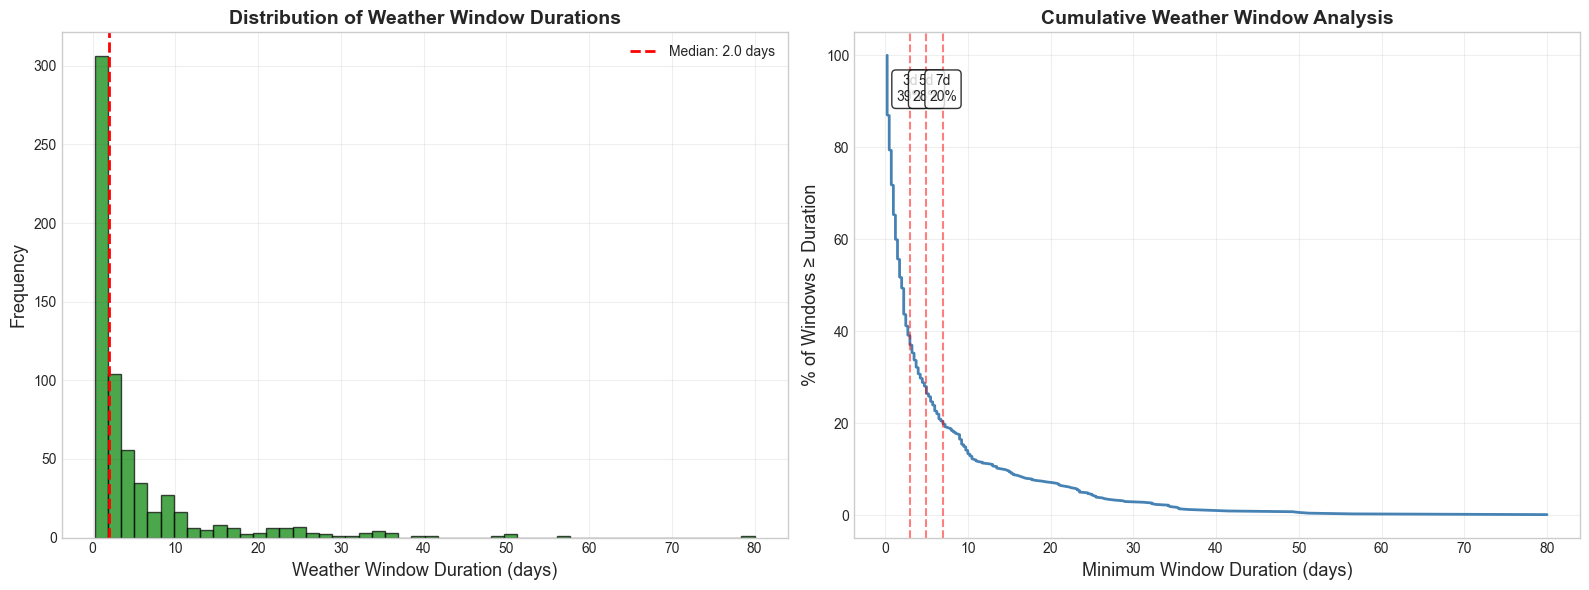


💡 How to read the right plot:
   • Find your required duration on x-axis (e.g., 5 days)
   • Read up to the curve, then left to y-axis
   • That's the % of windows that are long enough


In [6]:
# Visualize window durations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram of window durations
axes[0].hist(workable_days, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0].axvline(workable_days.median(), color='red', linestyle='--', linewidth=2,
                label=f'Median: {workable_days.median():.1f} days')
axes[0].set_xlabel('Weather Window Duration (days)', fontsize=13)
axes[0].set_ylabel('Frequency', fontsize=13)
axes[0].set_title('Distribution of Weather Window Durations', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Cumulative: "% of windows that are at least X days"
window_days_sorted = sorted(workable_days, reverse=True)
cumulative_pct = np.arange(1, len(window_days_sorted) + 1) / len(window_days_sorted) * 100
axes[1].plot(window_days_sorted, cumulative_pct, linewidth=2, color='steelblue')
axes[1].set_xlabel('Minimum Window Duration (days)', fontsize=13)
axes[1].set_ylabel('% of Windows ≥ Duration', fontsize=13)
axes[1].set_title('Cumulative Weather Window Analysis', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Add reference lines
for days in [3, 5, 7]:
    pct = (workable_days >= days).sum() / len(workable_days) * 100
    axes[1].axvline(days, color='red', linestyle='--', alpha=0.5)
    axes[1].text(days, 90, f'{days}d\n{pct:.0f}%', ha='center', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print("\n💡 How to read the right plot:")
print("   • Find your required duration on x-axis (e.g., 5 days)")
print("   • Read up to the curve, then left to y-axis")
print("   • That's the % of windows that are long enough")

### 🎯 Phase 2 Enhancement Idea #2: Weather Window Planning

**What:** Calculate probability of getting required consecutive days

**Example:**
- "I need 5 consecutive workable days"
- "How many 5-day windows per year?"
- "What months have best 5-day windows?"

**Value:** Critical for project scheduling and risk assessment

---
## Part 4: Persistence Analysis

**Why it matters:** How long do good/bad conditions last?
- If it's workable today, will it be workable tomorrow?
- If a storm hits, how long until conditions improve?

In [7]:
print("=" * 80)
print("⏳ PERSISTENCE ANALYSIS")
print("=" * 80)

print("\nIf conditions are WORKABLE now, what's the chance they stay workable?\n")

# Lag analysis
for hours in [6, 12, 24, 48, 72]:
    periods = hours // 6  # Convert to 6-hour periods
    
    # Shift the workable column
    df_sorted['workable_future'] = df_sorted['workable'].shift(-periods)
    
    # For rows that are workable now, what % are still workable in the future?
    currently_workable = df_sorted[df_sorted['workable'] == True]
    still_workable = currently_workable['workable_future'].sum()
    persistence = (still_workable / len(currently_workable)) * 100
    
    bar = '█' * int(persistence / 2)
    print(f"  After {hours:3d} hours: {persistence:5.1f}% still workable {bar}")

print("\n")
print("If conditions are NOT WORKABLE now, what's the chance they improve?\n")

for hours in [6, 12, 24, 48, 72]:
    periods = hours // 6
    
    df_sorted['workable_future'] = df_sorted['workable'].shift(-periods)
    
    # For rows that are NOT workable now, what % become workable?
    currently_not_workable = df_sorted[df_sorted['workable'] == False]
    becomes_workable = currently_not_workable['workable_future'].sum()
    improvement = (becomes_workable / len(currently_not_workable)) * 100
    
    bar = '█' * int(improvement / 2)
    print(f"  After {hours:3d} hours: {improvement:5.1f}% become workable {bar}")

print("\n💡 Interpretation:")
print("   • High persistence = Conditions are stable")
print("   • Low persistence = Conditions change rapidly")
print("   • Useful for short-term operational planning")

⏳ PERSISTENCE ANALYSIS

If conditions are WORKABLE now, what's the chance they stay workable?

  After   6 hours:  95.2% still workable ███████████████████████████████████████████████
  After  12 hours:  92.3% still workable ██████████████████████████████████████████████
  After  24 hours:  89.2% still workable ████████████████████████████████████████████
  After  48 hours:  86.4% still workable ███████████████████████████████████████████
  After  72 hours:  85.7% still workable ██████████████████████████████████████████


If conditions are NOT WORKABLE now, what's the chance they improve?

  After   6 hours:  23.8% become workable ███████████
  After  12 hours:  38.0% become workable ██████████████████
  After  24 hours:  53.3% become workable ██████████████████████████
  After  48 hours:  67.5% become workable █████████████████████████████████
  After  72 hours:  70.9% become workable ███████████████████████████████████

💡 Interpretation:
   • High persistence = Conditions are stable

### 🎯 Phase 2 Enhancement Idea #3: Persistence-Based Forecasting

**What:** Use historical persistence to estimate operation success probability

**Example:**
- "Conditions are workable now, 75% chance still OK in 24 hours"
- "Storm today, 60% chance improved by tomorrow"

**Value:** Helps with day-to-day operational decisions

---
## Part 5: Wave Steepness Analysis

**Why it matters:** Steep waves cause MORE vessel motion than gradual waves of same height!
- Steepness = Hs / Wavelength
- Steep waves (high Hs, short Tp) = Worst for vessels
- Long period swells (low Hs, long Tp) = Easier to work in

In [8]:
print("=" * 80)
print("📐 WAVE STEEPNESS ANALYSIS")
print("=" * 80)

# Calculate wavelength (deep water approximation)
# L = 1.56 * Tp^2 (meters)
df_sorted['wavelength'] = 1.56 * df_sorted['tp']**2

# Calculate steepness
df_sorted['steepness'] = df_sorted['hs'] / df_sorted['wavelength']

print(f"\n🌊 Wave Steepness Statistics:\n")
print(f"  Mean steepness: {df_sorted['steepness'].mean():.4f}")
print(f"  Median steepness: {df_sorted['steepness'].median():.4f}")
print(f"  Max steepness: {df_sorted['steepness'].max():.4f}")

# Classify by steepness
gentle = (df_sorted['steepness'] < 0.02).sum()
moderate = ((df_sorted['steepness'] >= 0.02) & (df_sorted['steepness'] < 0.04)).sum()
steep = (df_sorted['steepness'] >= 0.04).sum()

total = len(df_sorted)

print(f"\n📊 Steepness Classification:\n")
print(f"  Gentle (<0.02):   {gentle:6,} ({gentle/total*100:5.1f}%)")
print(f"  Moderate (0.02-0.04): {moderate:6,} ({moderate/total*100:5.1f}%)")
print(f"  Steep (>0.04):    {steep:6,} ({steep/total*100:5.1f}%)")

print(f"\n💡 Why steepness matters:")
print(f"   • Steep waves = More vessel motion (roll, pitch, heave)")
print(f"   • Two scenarios with Hs=2m:")
print(f"     - Hs=2m, Tp=12s → Gentle long-period swell")
print(f"     - Hs=2m, Tp=5s → Steep choppy seas")
print(f"   • Workability should consider BOTH Hs and Tp!")

📐 WAVE STEEPNESS ANALYSIS

🌊 Wave Steepness Statistics:

  Mean steepness: 0.0210
  Median steepness: 0.0194
  Max steepness: 0.0642

📊 Steepness Classification:

  Gentle (<0.02):    8,126 ( 51.2%)
  Moderate (0.02-0.04):  6,869 ( 43.3%)
  Steep (>0.04):       864 (  5.4%)

💡 Why steepness matters:
   • Steep waves = More vessel motion (roll, pitch, heave)
   • Two scenarios with Hs=2m:
     - Hs=2m, Tp=12s → Gentle long-period swell
     - Hs=2m, Tp=5s → Steep choppy seas
   • Workability should consider BOTH Hs and Tp!


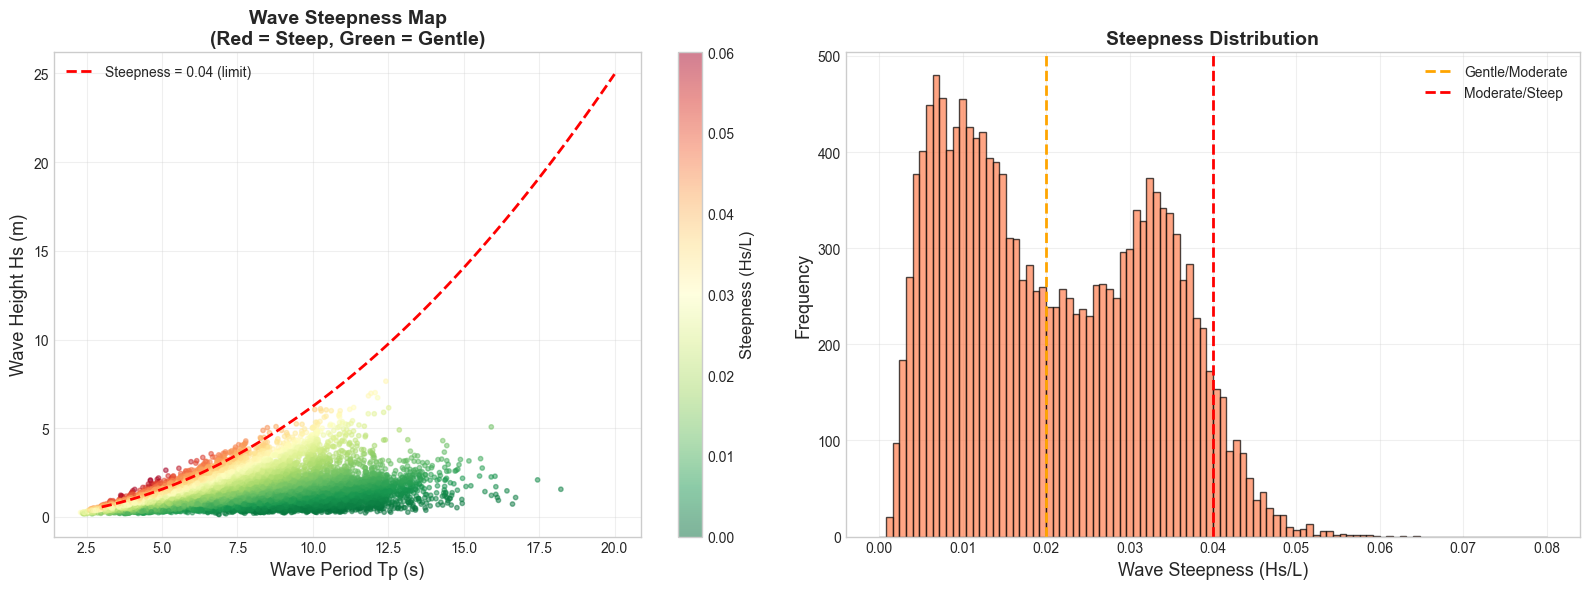


💡 Reading the left plot:
   • Points ABOVE red line = Steep waves (dangerous)
   • Points BELOW red line = Acceptable steepness
   • Even with low Hs, short Tp can make waves steep!


In [9]:
# Visualize steepness
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter: Hs vs Tp colored by steepness
scatter = axes[0].scatter(df_sorted['tp'], df_sorted['hs'], 
                         c=df_sorted['steepness'], cmap='RdYlGn_r',
                         s=10, alpha=0.5, vmin=0, vmax=0.06)
axes[0].set_xlabel('Wave Period Tp (s)', fontsize=13)
axes[0].set_ylabel('Wave Height Hs (m)', fontsize=13)
axes[0].set_title('Wave Steepness Map\n(Red = Steep, Green = Gentle)', 
                  fontsize=14, fontweight='bold')
cbar = plt.colorbar(scatter, ax=axes[0])
cbar.set_label('Steepness (Hs/L)', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Add steepness threshold line
tp_range = np.linspace(3, 20, 100)
# For steepness = 0.04, Hs = 0.04 * L = 0.04 * 1.56 * Tp^2
hs_steep = 0.04 * 1.56 * tp_range**2
axes[0].plot(tp_range, hs_steep, 'r--', linewidth=2, label='Steepness = 0.04 (limit)')
axes[0].legend()

# Histogram of steepness
axes[1].hist(df_sorted['steepness'], bins=100, edgecolor='black', 
             alpha=0.7, color='coral', range=(0, 0.08))
axes[1].axvline(0.02, color='orange', linestyle='--', linewidth=2, label='Gentle/Moderate')
axes[1].axvline(0.04, color='red', linestyle='--', linewidth=2, label='Moderate/Steep')
axes[1].set_xlabel('Wave Steepness (Hs/L)', fontsize=13)
axes[1].set_ylabel('Frequency', fontsize=13)
axes[1].set_title('Steepness Distribution', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Reading the left plot:")
print("   • Points ABOVE red line = Steep waves (dangerous)")
print("   • Points BELOW red line = Acceptable steepness")
print("   • Even with low Hs, short Tp can make waves steep!")

### 🎯 Phase 2 Enhancement Idea #4: Steepness-Based Workability

**What:** Add steepness criteria to workability calculations

**Example:**
- Traditional: "Hs < 2.5m"
- Enhanced: "Hs < 2.5m AND Steepness < 0.04"

**Value:** More realistic - accounts for wave period effects on vessel motions

---
## Part 6: Year-Over-Year Trends

**Why it matters:** Is workability improving or declining over time?
- Climate change effects
- Variability between years
- Long-term planning

In [10]:
print("=" * 80)
print("📅 YEAR-OVER-YEAR ANALYSIS")
print("=" * 80)

# Add year column
df_sorted['year'] = pd.to_datetime(df_sorted['time']).dt.year

# Exclude 2025 (incomplete)
df_complete_years = df_sorted[df_sorted['year'] < 2025].copy()

# Calculate workability by year
max_hs = 2.5
max_wind = 15.0

print(f"\nWorkability trend (Hs<{max_hs}m, Wind<{max_wind}m/s):\n")

yearly_stats = []

for year in sorted(df_complete_years['year'].unique()):
    year_data = df_complete_years[df_complete_years['year'] == year]
    
    workable = ((year_data['hs'] < max_hs) & (year_data['wind_speed'] < max_wind)).sum()
    total = len(year_data)
    workability = (workable / total) * 100
    
    mean_hs = year_data['hs'].mean()
    max_hs_year = year_data['hs'].max()
    
    yearly_stats.append({
        'year': year,
        'workability': workability,
        'mean_hs': mean_hs,
        'max_hs': max_hs_year,
        'records': total
    })
    
    print(f"  {year}: {workability:5.1f}% workable | Mean Hs: {mean_hs:.2f}m | Max: {max_hs_year:.2f}m")

yearly_df = pd.DataFrame(yearly_stats)

print(f"\n📊 Summary Statistics:")
print(f"  Best year: {yearly_df.loc[yearly_df['workability'].idxmax(), 'year']:.0f} ({yearly_df['workability'].max():.1f}%)")
print(f"  Worst year: {yearly_df.loc[yearly_df['workability'].idxmin(), 'year']:.0f} ({yearly_df['workability'].min():.1f}%)")
print(f"  Range: {yearly_df['workability'].max() - yearly_df['workability'].min():.1f}% points")
print(f"  Std dev: {yearly_df['workability'].std():.1f}%")

📅 YEAR-OVER-YEAR ANALYSIS

Workability trend (Hs<2.5m, Wind<15.0m/s):

  2015:  91.5% workable | Mean Hs: 1.36m | Max: 6.09m
  2016:  92.3% workable | Mean Hs: 1.34m | Max: 4.59m
  2017:  90.3% workable | Mean Hs: 1.38m | Max: 6.15m
  2018:  91.0% workable | Mean Hs: 1.34m | Max: 6.03m
  2019:  92.5% workable | Mean Hs: 1.35m | Max: 5.99m
  2020:  92.4% workable | Mean Hs: 1.35m | Max: 5.22m
  2021:  90.3% workable | Mean Hs: 1.35m | Max: 7.65m
  2022:  92.0% workable | Mean Hs: 1.35m | Max: 5.27m
  2023:  92.5% workable | Mean Hs: 1.37m | Max: 7.00m
  2024:  90.6% workable | Mean Hs: 1.36m | Max: 6.06m

📊 Summary Statistics:
  Best year: 2019 (92.5%)
  Worst year: 2017 (90.3%)
  Range: 2.3% points
  Std dev: 0.9%


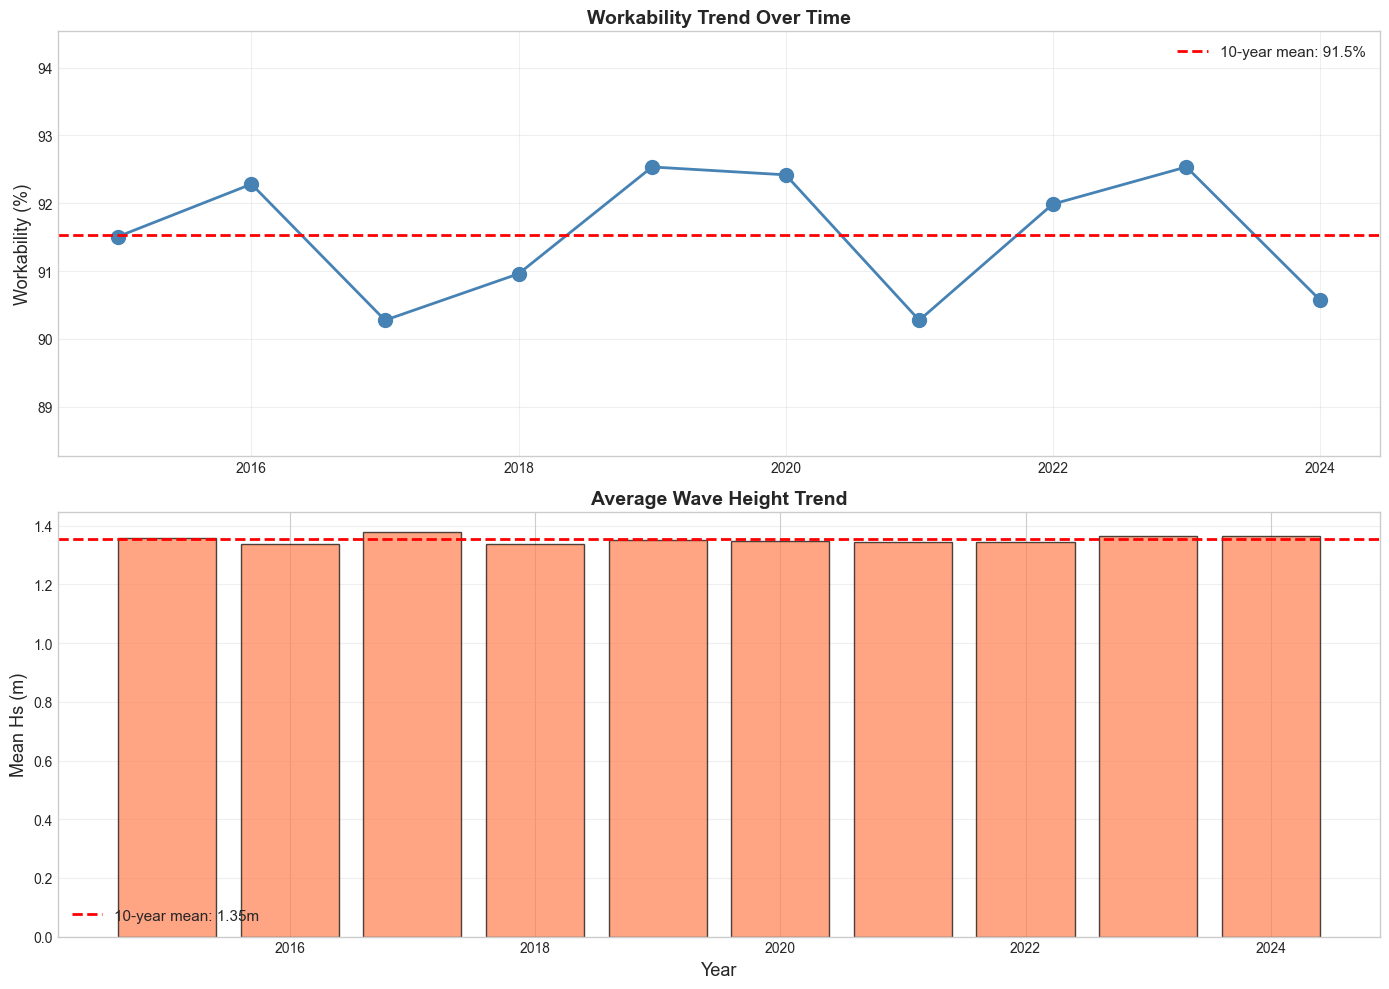


💡 What to look for:
   • Increasing trend = Conditions worsening over time
   • Decreasing trend = Conditions improving
   • High variability = Unreliable, some years much better than others


In [11]:
# Plot trends
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Workability trend
axes[0].plot(yearly_df['year'], yearly_df['workability'], 'o-', 
             linewidth=2, markersize=10, color='steelblue')
axes[0].axhline(yearly_df['workability'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f"10-year mean: {yearly_df['workability'].mean():.1f}%")
axes[0].set_ylabel('Workability (%)', fontsize=13)
axes[0].set_title('Workability Trend Over Time', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(yearly_df['workability'].min() - 2, yearly_df['workability'].max() + 2)

# Mean Hs trend
axes[1].bar(yearly_df['year'], yearly_df['mean_hs'], 
            color='coral', alpha=0.7, edgecolor='black')
axes[1].axhline(yearly_df['mean_hs'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f"10-year mean: {yearly_df['mean_hs'].mean():.2f}m")
axes[1].set_xlabel('Year', fontsize=13)
axes[1].set_ylabel('Mean Hs (m)', fontsize=13)
axes[1].set_title('Average Wave Height Trend', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n💡 What to look for:")
print("   • Increasing trend = Conditions worsening over time")
print("   • Decreasing trend = Conditions improving")
print("   • High variability = Unreliable, some years much better than others")

### 🎯 Phase 2 Enhancement Idea #5: Variability & Risk Assessment

**What:** Show year-to-year variability in workability

**Example:**
- "Average workability: 85%"
- "But ranges from 78% (bad year) to 91% (good year)"
- "Plan for bad year, benefit from good year"

**Value:** Better risk assessment for multi-year projects

---
## Part 7: Summary of Enhancement Opportunities

In [12]:
print("=" * 80)
print("🎯 PHASE 2 ENHANCEMENT OPPORTUNITIES")
print("=" * 80)

enhancements = [
    {
        'name': '1. Directional Workability',
        'description': 'Account for wave/wind direction limits',
        'benefit': 'More accurate for directional-sensitive operations',
        'difficulty': '⭐⭐ Moderate',
        'available': 'dir' in df.columns
    },
    {
        'name': '2. Weather Window Analysis',
        'description': 'Find consecutive workable days',
        'benefit': 'Critical for operations needing continuous work',
        'difficulty': '⭐⭐ Moderate',
        'available': True
    },
    {
        'name': '3. Persistence Forecasting',
        'description': 'Probability conditions stay/improve',
        'benefit': 'Day-to-day operational decisions',
        'difficulty': '⭐⭐ Moderate',
        'available': True
    },
    {
        'name': '4. Steepness Criteria',
        'description': 'Include wave steepness in limits',
        'benefit': 'More realistic vessel motion estimates',
        'difficulty': '⭐ Easy',
        'available': True
    },
    {
        'name': '5. Year-Over-Year Trends',
        'description': 'Show annual variability',
        'benefit': 'Better risk assessment',
        'difficulty': '⭐ Easy',
        'available': True
    },
    {
        'name': '6. Scatter-Based Limits',
        'description': 'Exclude specific Hs+Tp combinations',
        'benefit': 'RAO-like limits without full RAO',
        'difficulty': '⭐⭐ Moderate',
        'available': True
    },
    {
        'name': '7. Weekly/Bi-weekly Patterns',
        'description': 'Finer resolution than monthly',
        'benefit': 'Better scheduling precision',
        'difficulty': '⭐ Easy',
        'available': True
    },
    {
        'name': '8. Multi-Day Project Planner',
        'description': 'Find best dates for X-day project',
        'benefit': 'Optimize project timing',
        'difficulty': '⭐⭐⭐ Advanced',
        'available': True
    }
]

print("\n📋 Available Enhancements:\n")

for i, enh in enumerate(enhancements, 1):
    status = "✅ Ready" if enh['available'] else "⚠️  Need data"
    print(f"\n{enh['name']}")
    print(f"  What: {enh['description']}")
    print(f"  Why: {enh['benefit']}")
    print(f"  Difficulty: {enh['difficulty']}")
    print(f"  Status: {status}")

print("\n" + "=" * 80)
print("💡 RECOMMENDED NEXT STEPS")
print("=" * 80)

print("\nStart with these 3 quick wins:")
print("  1️⃣  Weather Windows (Part 3) - Most requested by industry")
print("  2️⃣  Steepness Criteria (Part 5) - Easy to add, big value")
print("  3️⃣  Year-over-Year Trends (Part 6) - Shows variability/risk")

print("\nThen add advanced features:")
print("  4️⃣  Directional Workability (Part 2) - If direction data available")
print("  5️⃣  Persistence Analysis (Part 4) - For short-term planning")
print("  6️⃣  Multi-Day Project Planner (Part 8) - Most complex but powerful")

print("\n✅ This notebook gave you the foundation!")
print("   Now we can implement these in Phase 2...")

🎯 PHASE 2 ENHANCEMENT OPPORTUNITIES

📋 Available Enhancements:


1. Directional Workability
  What: Account for wave/wind direction limits
  Why: More accurate for directional-sensitive operations
  Difficulty: ⭐⭐ Moderate
  Status: ✅ Ready

2. Weather Window Analysis
  What: Find consecutive workable days
  Why: Critical for operations needing continuous work
  Difficulty: ⭐⭐ Moderate
  Status: ✅ Ready

3. Persistence Forecasting
  What: Probability conditions stay/improve
  Why: Day-to-day operational decisions
  Difficulty: ⭐⭐ Moderate
  Status: ✅ Ready

4. Steepness Criteria
  What: Include wave steepness in limits
  Why: More realistic vessel motion estimates
  Difficulty: ⭐ Easy
  Status: ✅ Ready

5. Year-Over-Year Trends
  What: Show annual variability
  Why: Better risk assessment
  Difficulty: ⭐ Easy
  Status: ✅ Ready

6. Scatter-Based Limits
  What: Exclude specific Hs+Tp combinations
  Why: RAO-like limits without full RAO
  Difficulty: ⭐⭐ Moderate
  Status: ✅ Ready

7. Week

---
## 🎓 Congratulations!

You've discovered 8 ways to enhance your workability analysis!

**What you learned:**
1. Your data contains much more than just wave height
2. Direction, persistence, steepness all matter
3. Weather windows are critical for real operations
4. Year-to-year variability affects risk

**Next:** Implement these enhancements in Phase 2! 🚀